<center><h1> Parameterized Mass N Tag </h1>
John Ignacio R.M. 10 AGO 2020</center>

In [1]:
import numpy as np
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada2.model import BinClassifModelV1 as BC1
from ada2.data import read_dataset
from ada2.plot import plot_confidence_matrix
from ada2.data import pop_col_from_dfs, StandardScaler, shuffle, trainvaltest_split_bytag, rotate_vectors
from ada2 import col_names
import pandas as pd
from IPython.core.display import display, HTML

Using TensorFlow backend.
Welcome to JupyROOT 6.20/04


In [2]:
source_path = "../processed_data/xtohh"
masses = [1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000]
signal = "Xtohh"
bg = "Xtohh_background"
seed = 420

In [3]:
dfs = {mass: read_dataset(source_path, signal+str(mass), bg, "SR", None) for mass in masses}
df = pd.concat(dfs, names = ["mass", None])
df = df.reset_index(level = 0).reset_index(drop = True)
df

,mass,EventWeight,label,m_FJNbtagJets,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,1000,0.000564,1,1,469.99335,-0.103794,0.135230,114371.484,349.74603,0.179922,-3.006100,78700.110,3.141330,3.154116,-0.229120,59.949210,841.53326,120.247360
1,1000,0.000727,1,1,414.17117,-0.202314,-2.693024,96535.860,307.60794,0.618064,0.463957,82491.734,3.126203,3.232054,0.459876,29.781347,795.17010,106.704720
2,1000,0.000558,1,0,351.65167,-1.617167,-0.296893,64543.543,458.70813,0.470267,2.712189,89244.130,3.009082,3.662234,0.021388,177.911560,1292.02100,119.537840
3,1000,0.000651,1,0,340.53226,-1.063241,0.413148,158252.700,513.99980,0.273971,-2.653321,99405.305,3.066469,3.345351,-0.390553,33.973476,1063.40870,176.290500
4,1000,0.000724,1,1,530.72906,-0.665690,-2.322554,117427.940,350.49396,-0.398393,0.962083,95093.410,2.998548,3.010438,-0.278436,80.552870,894.42880,190.484800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589710,3000,0.004849,0,0,555.51556,-0.784520,1.992371,50107.645,426.92703,1.330739,-1.025856,90372.520,3.018227,3.685650,-0.235375,27.074110,1576.83370,141.915010
589711,3000,0.007816,0,0,728.12130,1.208702,-1.652860,151533.310,743.45490,0.397559,1.279434,92246.766,2.932294,3.042417,-0.384011,51.493763,1605.37600,154.472730
589712,3000,0.003214,0,0,502.78928,-0.422378,2.242108,44771.990,399.19644,0.375234,-0.829968,114803.970,3.072076,3.173931,0.131922,54.890198,984.82870,108.171340
589713,3000,0.003214,0,0,534.98376,-0.635762,-3.080583,32551.125,363.21560,-1.299729,0.130214,146851.560,3.072388,3.143314,-0.164930,25.033915,953.04474,174.455020


In [4]:
def trainvaltest_split_bymasstag(x, y, seed, train_size, val_size, test_size, masses):
    x_mass = {mass: x[x["mass"] == mass] for mass in masses}
    y_mass = {mass: y[x["mass"] == mass] for mass in masses}

    x_train, x_val, x_test, y_train, y_val, y_test = ({},{},{},{},{},{})

    for t in masses:
        x_train[t], x_val[t], x_test[t], y_train[t], y_val[t], y_test[t] = trainvaltest_split_bytag(
            x_mass[t], y_mass[t], seed, train_size, val_size, test_size
        )
    x_train, y_train = shuffle(pd.concat(x_train.values()),np.concatenate(list(y_train.values())),random_state=seed)
    x_val, y_val = shuffle(pd.concat(x_val.values()),np.concatenate(list(y_val.values())),random_state=seed)
    x_test, y_test =shuffle(pd.concat(x_test.values()),np.concatenate(list(y_test.values())),random_state=seed)

    return (x_train.reset_index(drop=True), x_val.reset_index(drop=True), x_test.reset_index(drop=True),
    y_train, y_val, y_test)

def split_dataset_bymasstag(df, train_size, val_size, test_size, seed, masses):

    x = df.drop(columns = ["label"])
    y = df["label"].values

    x_train, x_val, x_test, y_train, y_val, y_test = trainvaltest_split_bymasstag(x,y,seed,train_size,val_size,test_size,masses)
    x_test_bymass = {mass: x_test[(x_test["mass"] == mass) & (x_test[col_names["tag"]] == 2)]  for mass in masses}
    y_test_bymass = {mass: y_test[(x_test["mass"] == mass) & (x_test[col_names["tag"]] == 2)]  for mass in masses}

    #object where all the datasets will be stored
    sets = {}

    #all the sets for train, val and test will be stored here
    w_train, w_val, w_test = pop_col_from_dfs([x_train, x_val, x_test], col_names["weight"])
    sets["w"] = {"train": w_train, "val": w_val, "test": w_test}

    #scale
    scaler = StandardScaler().fit(x_train)
    x_train, x_val, x_test = [pd.DataFrame(scaler.transform(df),columns=df.columns) for df in [x_train, x_val, x_test]]
    sets["x"] = {"train": x_train, "val": x_val, "test": x_test}

    #reshape y
    y_train, y_val, y_test = rotate_vectors([y_train, y_val, y_test])
    sets["y"] = {"train": y_train, "val": y_val, "test": y_test}

    for mass in masses:
        sets[mass] = {}
        x_test, y_test = (x_test_bymass[mass], y_test_bymass[mass])
        sets[mass]["w_test"] = pop_col_from_dfs([x_test], col_names["weight"])[0]
        sets[mass]["x_test"] = pd.DataFrame(scaler.transform(x_test),columns=x_test.columns)
        sets[mass]["y_test"] = rotate_vectors([y_test])[0]

    return sets

In [5]:
sets = split_dataset_bymasstag(df, 0.6, 0.2, 0.2, seed, masses)
sets.keys()

dict_keys(['w', 'x', 'y', 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000])

In [6]:
x_train, x_val, x_test = sets["x"].values()
y_train, y_val, y_test = sets["y"].values()
w_train, w_val, w_test = sets["w"].values()
print(x_train.shape, x_val.shape, x_test.shape)

(353811, 16) (117948, 16) (117956, 16)


Train on 353811 samples, validate on 117948 samples
Epoch 1/50
353811/353811 [==============================] - 54s 151us/step - loss: 7.4198e-04 - val_loss: 5.3179e-04
Epoch 2/50
353811/353811 [==============================] - 60s 170us/step - loss: 5.6213e-04 - val_loss: 4.6705e-04
Epoch 3/50
353811/353811 [==============================] - 70s 198us/step - loss: 5.0204e-04 - val_loss: 3.8456e-04
Epoch 4/50
353811/353811 [==============================] - 57s 161us/step - loss: 4.6185e-04 - val_loss: 3.6849e-04
Epoch 5/50
353811/353811 [==============================] - 55s 156us/step - loss: 4.3821e-04 - val_loss: 3.6425e-04
Epoch 6/50
353811/353811 [==============================] - 55s 157us/step - loss: 4.3100e-04 - val_loss: 3.5757e-04
Epoch 7/50
353811/353811 [==============================] - 55s 157us/step - loss: 4.1462e-04 - val_loss: 3.4377e-04
Epoch 8/50
353811/353811 [==============================] - 55s 157us/step - loss: 4.0045e-04 - val_loss: 3.2640e-04
Epoch 9/50
3

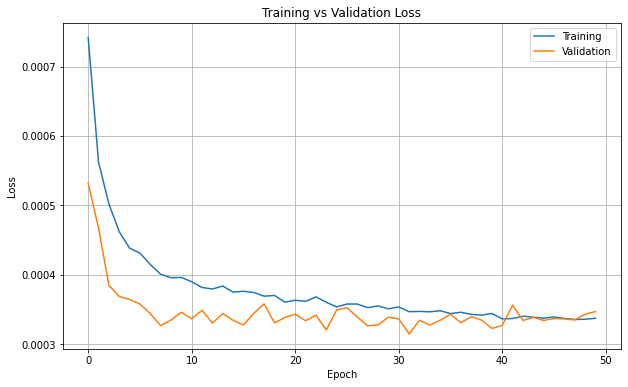

2020-08-10 18:17:55.933018: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-08-10 18:17:55.942920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-10 18:17:55.943192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2020-08-10 18:17:55.943225: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-08-10 18:17:55.943241: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-08-10 18:17:55.944797: I tensorflow/stream_executor/platform/def

In [7]:
model = BC1(x_train.shape[1])
model.fit(x_train, y_train, w_train, x_val, y_val, w_val, 50)
model.plot_loss()

Accuracy: 0.8378545765186719


,0,1,macro avg,weighted avg
precision,0.993429,0.619088,0.806259,0.895677
recall,0.785746,0.985295,0.885521,0.837855
f1-score,0.877466,0.760397,0.818932,0.846896
support,0.530514,0.187494,0.718008,0.718008


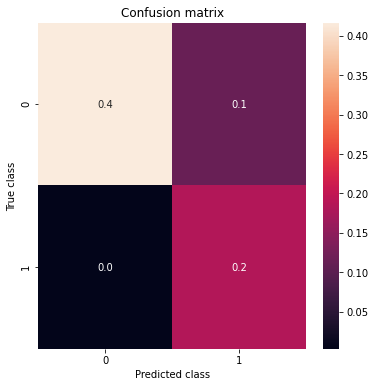

Accuracy: 0.8809496542715793


,0,1,macro avg,weighted avg
precision,0.964208,0.853732,0.908970,0.892154
recall,0.683042,0.986480,0.834761,0.880950
f1-score,0.799629,0.915318,0.857473,0.875083
support,0.532309,0.998274,1.530583,1.530583


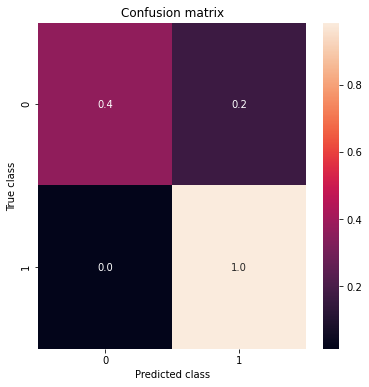

Accuracy: 0.8948565510953854


,0,1,macro avg,weighted avg
precision,0.981064,0.873531,0.927297,0.905355
recall,0.657417,0.994666,0.826042,0.894857
f1-score,0.787276,0.930171,0.858723,0.887881
support,0.655538,1.559477,2.215015,2.215015


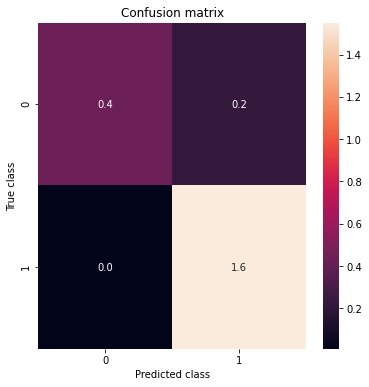

Accuracy: 0.8357765571341227


,0,1,macro avg,weighted avg
precision,0.848869,0.834880,0.841875,0.837803
recall,0.260272,0.987762,0.624017,0.835777
f1-score,0.398392,0.904910,0.651651,0.799089
support,0.487778,1.847002,2.334780,2.334780


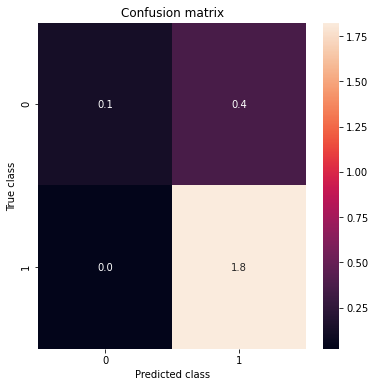

Accuracy: 0.975632577812215


,0,1,macro avg,weighted avg
precision,0.890507,0.982536,0.936521,0.974902
recall,0.805269,0.991043,0.898156,0.975633
f1-score,0.845746,0.986771,0.916259,0.975073
support,0.178088,1.968723,2.146811,2.146811


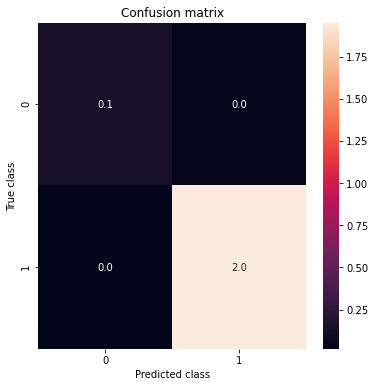

Accuracy: 0.9718394275451414


,0,1,macro avg,weighted avg
precision,0.932665,0.979412,0.956038,0.971543
recall,0.897501,0.986885,0.942193,0.971839
f1-score,0.914745,0.983134,0.948940,0.971622
support,0.392325,1.938392,2.330717,2.330717


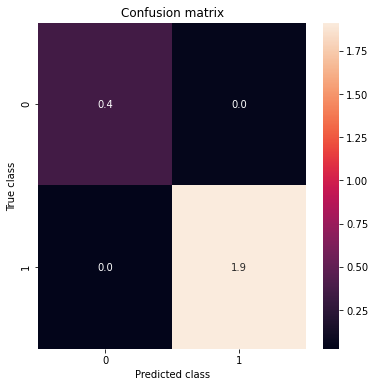

Accuracy: 0.9704079600811947


,0,1,macro avg,weighted avg
precision,0.971678,0.969922,0.970800,0.970432
recall,0.925165,0.988949,0.957057,0.970408
f1-score,0.947852,0.979343,0.963597,0.970189
support,0.633619,1.546116,2.179736,2.179736


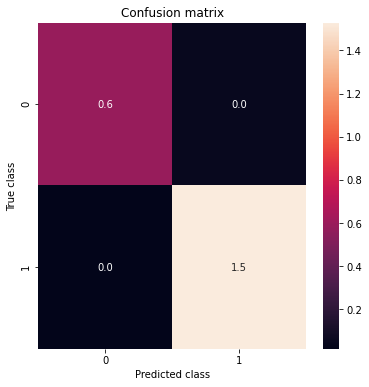

Accuracy: 0.9875653179868176


,0,1,macro avg,weighted avg
precision,0.965058,1.000061,0.982559,0.988003
recall,1.000114,0.980971,0.990542,0.987565
f1-score,0.982273,0.990424,0.986349,0.987616
support,0.476165,0.906135,1.382300,1.382300


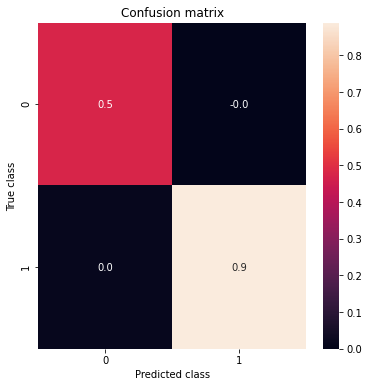

In [8]:
for mass in masses:
    display(HTML(f"<h2>Xtohh {mass} Tag 2</h2>"))
    x_test_mass = sets[mass]["x_test"]
    y_test_mass = sets[mass]["y_test"]
    w_test_mass = sets[mass]["w_test"]

    eval = model.complete_evaluation(
        x_test_mass, y_test_mass, w_test_mass, 0.4, save = False
    )

    print("Accuracy:", eval["weighted_accuracy"])
    display(pd.DataFrame(eval["weighted_class_report"]))
    plot_confidence_matrix(eval["weighted_cm"], 6, 6, '.1f')

In [9]:
model.save("../saved_models", "param_tagmass_ago2020")